In [42]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [43]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

mnist.json.gz


In [44]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

mkdir: cannot create directory ‘/home/aistudio/external-libraries’: File exists
Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 122kB 19.5MB/s eta 0:00:01


In [45]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

In [46]:
import paddle
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import paddle.nn.functional as F
import random
from paddle.nn import Linear, Conv2D, MaxPool2D
import os
from paddle.io import Dataset
import json
import gzip

In [47]:
# 定义数据集读取器
def load_data(mode='train',BATCHSIZE = 100):
    # 读取数据文件
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    data = json.load(gzip.open(datafile))
    # 读取数据集中的训练集，验证集和测试集
    train_set, val_set, eval_set = data

    # 数据集相关参数，图片高度IMG_ROWS, 图片宽度IMG_COLS
    IMG_ROWS = 28
    IMG_COLS = 28
    # 根据输入mode参数决定使用训练集，验证集还是测试
    if mode == 'train':
        imgs = train_set[0]
        labels = train_set[1]
    elif mode == 'valid':
        imgs = val_set[0]
        labels = val_set[1]
    elif mode == 'eval':
        imgs = eval_set[0]
        labels = eval_set[1]
    # 获得所有图像的数量
    imgs_length = len(imgs)
    # 验证图像数量和标签数量是否一致
    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(
                  len(imgs), len(labels))

    index_list = list(range(imgs_length))

    # 读入数据时用到的batchsize
    BATCHSIZE = 100

    # 定义数据生成器
    def data_generator():
        # 训练模式下，打乱训练数据
        if mode == 'train':
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        # 按照索引读取数据
        for i in index_list:
            # 读取图像和标签，转换其尺寸和类型
            img = np.reshape(imgs[i], [1, IMG_ROWS, IMG_COLS]).astype('float32')
            label = np.reshape(labels[i], [1]).astype('int64')
            imgs_list.append(img) 
            labels_list.append(label)
            # 如果当前数据缓存达到了batch size，就返回一个批次数据
            if len(imgs_list) == BATCHSIZE:
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据缓存列表
                imgs_list = []
                labels_list = []

        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)

    return data_generator

In [48]:
# 残差模型的建立
#首先创建残差元
class Residual(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2D(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2D(out_channels, out_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2D(out_channels)
        self.bn2 = nn.BatchNorm2D(out_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y + X)

# 然后创建残差块
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    if first_block:
        assert in_channels == out_channels  # 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return nn.Sequential(*blk)

# 最后建立残差网络
class my_resnet(nn.Layer):
    def __init__(self):
        super(my_resnet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2D(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
            nn.BatchNorm2D(64),
            nn.ReLU(),
            nn.MaxPool2D(kernel_size=2, stride=2),
            
            resnet_block(64,64,3,True),
            resnet_block(64, 128, 4),
            resnet_block(128, 256, 2)
        )
        self.avg=nn.AvgPool2D(kernel_size=2)
        self.flatten=nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(256*2*2, 10)
        )

    def forward(self, x,label=None):
        x = self.net(x)
        # x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.avg(x)
        # x=paddle.reshape(x, [x.shape[0], 64])
        x=self.flatten(x)
        x = self.fc(x)
        x=F.softmax(x,axis=1)
        if label is not None:
             acc = paddle.metric.accuracy(input=x, label=label)
             return x, acc
        else:
             return x

In [49]:
#设置随机种子
paddle.seed(0)
#仅优化算法的设置有所差别
def train(model):
    BATCH_SIZE = 100
    EPOCH_NUM = 10
    #开启GPU
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')
    # device = paddle.device.get_device()
    # paddle.set_device(device)
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train',BATCHSIZE=BATCH_SIZE)
    
    # total_steps = (int(50000//BATCH_SIZE) + 1) * EPOCH_NUM
    # lr = paddle.optimizer.lr.PolynomialDecay(learning_rate=0.01, decay_steps=total_steps, end_lr=0.001)
    # 使用Adam优化器
    opt = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
    
    #建立这些用于记录作图
    iter=0
    iters=[]
    losses=[]
    acces=[]
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)

            #前向计算的过程
            predicts, acc= model(images,labels)
            #计算损失，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了100批次的数据，打印下当前Loss的情况
            if batch_id % 100 == 0:
                print("epoch: {}, batch: {}, loss is: {}, acc is {}".format(epoch_id, batch_id, avg_loss.numpy(), acc.numpy()))
                iters.append(iter)
                losses.append(avg_loss.numpy())
                acces.append(acc.numpy())
                iter = iter + 100
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    
    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')
    return iters, losses,acces

In [50]:
#创建模型    
model = my_resnet()
#启动训练过程
iters, losses,acces = train(model)

loading mnist dataset from ./work/mnist.json.gz ......
epoch: 0, batch: 0, loss is: [2.3216734], acc is [0.11]
epoch: 0, batch: 100, loss is: [2.2281046], acc is [0.23]
epoch: 0, batch: 200, loss is: [1.8664535], acc is [0.59]
epoch: 0, batch: 300, loss is: [1.9733526], acc is [0.48]
epoch: 0, batch: 400, loss is: [2.031274], acc is [0.42]
epoch: 1, batch: 0, loss is: [1.7183694], acc is [0.74]
epoch: 1, batch: 100, loss is: [1.755754], acc is [0.7]
epoch: 1, batch: 200, loss is: [1.7390223], acc is [0.72]
epoch: 1, batch: 300, loss is: [1.7477121], acc is [0.71]
epoch: 1, batch: 400, loss is: [1.695945], acc is [0.76]
epoch: 2, batch: 0, loss is: [1.6673926], acc is [0.79]
epoch: 2, batch: 100, loss is: [1.6137897], acc is [0.85]
epoch: 2, batch: 200, loss is: [1.5726486], acc is [0.89]
epoch: 2, batch: 300, loss is: [1.6289306], acc is [0.82]
epoch: 2, batch: 400, loss is: [1.5910398], acc is [0.87]
epoch: 3, batch: 0, loss is: [1.6194301], acc is [0.84]
epoch: 3, batch: 100, loss is

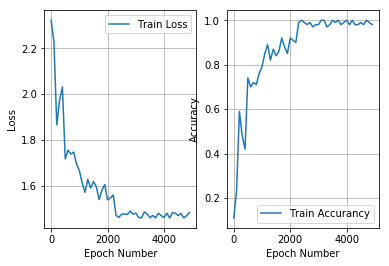

In [51]:
# 作图训练过程的训练集准确率变化
plt.subplot(1, 2, 1)
plt.plot(iters,losses,label='Train Loss')
plt.legend(['Train Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iters,acces,label='Train Accurancy')
plt.legend(['Train Accurancy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

In [52]:
# 对模型的效果使用测试集进行检验
def evaluation(model):
    print('start evaluation .......')
    # 定义预测过程
    params_file_path = 'mnist.pdparams'
    # 加载模型参数
    param_dict = paddle.load(params_file_path)
    model.load_dict(param_dict)

    model.eval()
    eval_loader = load_data('eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        images, labels = data
        images = paddle.to_tensor(images)
        labels = paddle.to_tensor(labels)
        predicts, acc = model(images, labels)
        loss = F.cross_entropy(input=predicts, label=labels)
        avg_loss = paddle.mean(loss)
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    
    #计算多个batch的平均损失和准确率
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()

    print('loss={}, acc={}'.format(avg_loss_val_mean, acc_val_mean))

model = my_resnet()
evaluation(model)

start evaluation .......
loading mnist dataset from ./work/mnist.json.gz ......
loss=1.4709223198890686, acc=0.9903000074625016
